In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pprint
import lorem
import random
import re
import os
import json

from transformers import BertTokenizer, GPT2Tokenizer

### Setup Words Vocabulary

In [3]:
def download_vocab(name="gpt2", path="./"):
    tok = GPT2Tokenizer.from_pretrained(name)
    tok.save_pretrained(path)
    
    os.remove(os.path.join(path, "tokenizer_config.json"))
    os.remove(os.path.join(path, "special_tokens_map.json"))
    print(f"{name} vocabulary downloaded to path: {path}")


path = "../datasets/clean/gpt2vocab"
download_vocab(path=path)

gpt2 vocabulary downloaded to path: ../datasets/clean/gpt2vocab


**Some changes should be done manualy from text editor...**

In [5]:
import  re
import os
import json

src_path = "../datasets/clean/gpt2vocab/vocab.json"
regex = {
    r'^(.)\1{2,}$': "m",        # match repetitive letters (3 or more)
    r'-?\d+': "s",              # search integers
    r'\\u[0-9a-fA-F]{4}': "s",   # search unicode caracters
    r'([@$,%^!&*)(._+\-=\[\]}{;":\\|,.<>?/~`]{2,})': "m", # random special caracters
}

print("Regex to remove:")
print(regex)
print("="*100)

with open(src_path, "r", encoding="utf-8") as f:
    vocab = json.load(f)
    print(f"initial vocab length: {len(vocab)}")
    print("="*100)
    to_delete = []
    print("to delete:")
    for r, t in regex.items():
        if t == "m":
            for word, id in vocab.items():
                if bool(re.fullmatch(r, word)):
                    # delete word from vocab
                    to_delete.append(word)
        else:
            for word, id in vocab.items():
                if bool(re.match(r, word)):
                    # delete word from vocab
                    to_delete.append(word)
        
    print(to_delete, "\n")
    for word in set(to_delete):
        del vocab[word]
        
    print("="*100) 
    print(f"final vocab length: {len(vocab)}")
    print("="*100)

dest_path = "../utils/tokenier/vocab/vocab.json"
with open(dest_path, "w") as f:
    json.dump(vocab, f, indent=4)
    
print("done!")

Regex to remove:
{'^(.)\\1{2,}$': 'm', '-?\\d+': 's', '\\\\u[0-9a-fA-F]{4}': 's', '([@$,%^!&*)(._+\\-=\\[\\]}{;":\\\\|,.<>?/~`]{2,})': 'm'}
initial vocab length: 40944
to delete:
['!!!', '!!!!', '!!!!!', '!!!!!!!!', '"""', '###', '####', '########', '################', '################################', '$$$$', '%%%%', "''''", ')))', '))))', '***', '****', '*****', '********', '************', '****************', '********************************', '+++', '++++', '++++++++', '++++++++++++++++', ',,,,', ',,,,,,,,', '---', '----', '-----', '------', '-------', '--------', '---------', '----------', '-----------', '------------', '-------------', '--------------', '---------------', '----------------', '--------------------', '------------------------', '--------------------------------', '------------------------------------------------', '--------------------------------------------------------', '----------------------------------------------------------------', '...', '....', '.....',

**NOTE:** the following two cells should be run one single time

In [7]:
with open(dest_path, "r") as f:
    print(f"initial length: {len(vocab)}")
    vocab = json.load(f)
    lower_vocab = {key.lower(): value for key, value in vocab.items()}
    new_vocab = {key: idx+1 for idx, key in enumerate(lower_vocab)}
    print(f"new length: {len(lower_vocab)}")

with open(dest_path, "w") as f:
    json.dump(new_vocab, f, indent=4)

initial length: 39305
new length: 30675


In [8]:
keywords_file_path = "../datasets/clean/keywords.txt"
vocab_file_path = "../utils/tokenier/vocab/vocab.json"

with open(keywords_file_path, "r") as keywords_file, open(vocab_file_path, "r") as vocab_file:
    vocab = json.load(vocab_file)
    print(f"Initial vocab length: {len(vocab)}")
    for kw in keywords_file:
        for w in kw.lower().replace("\n", "").split(" "):
            if w not in vocab:
                vocab[w] = len(vocab) + 1


placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
for p in placeholders:
    vocab[p] = len(vocab) + 1



with open(vocab_file_path, "w") as f:
    json.dump(vocab, f, indent=4)
    
print("done!")
print(f"New vocab length: {len(vocab)}")

Initial vocab length: 30675
done!
New vocab length: 30990


#### save the tokenizer into a file

In [9]:
vocab_file = "../utils/tokenier/vocab/vocab.json"
merges_file = "../utils/tokenier/vocab/merges.txt"
tokenizer = GPT2Tokenizer(vocab_file=vocab_file, 
                          merges_file=merges_file,
                          unk_token="<|unk|>",
                          bos_token="<|bos|>",
                          eos_token="<|eos|>"
                         )

special_tokens_dict = {'additional_special_tokens': placeholders}
tokenizer.add_special_tokens(special_tokens_dict)

0

In [10]:
path = "../utils/tokenier/gpt2tokenizer/"
tokenizer.save_pretrained(path)

('../utils/tokenier/gpt2tokenizer/tokenizer_config.json',
 '../utils/tokenier/gpt2tokenizer/special_tokens_map.json',
 '../utils/tokenier/gpt2tokenizer/vocab.json',
 '../utils/tokenier/gpt2tokenizer/merges.txt',
 '../utils/tokenier/gpt2tokenizer/added_tokens.json')

#### Get and setup data

In [11]:
with open("../datasets/clean/sqli.txt") as source1:
    source1 = list(source1)

source2 = pd.read_csv("../datasets/raw/sql_dataset.csv", header=None)
source2 = list(source2[0])
sqli = source1

In [12]:
source1[:5]

['SELECT * FROM Customers;\n',
 "SELECT CustomerName, Email FROM Customers WHERE City = 'Paris';\n",
 'SELECT ProductID, ProductName, Price FROM Products ORDER BY Price ASC LIMIT 20;\n',
 'SELECT o.OrderID, c.CustomerName, p.ProductName FROM Orders o JOIN Customers c ON o.CustomerID = c.CustomerID JOIN Products p ON o.ProductID = p.ProductID;\n',
 "SELECT EmployeeID, FirstName, LastName, Department FROM Employees WHERE Department IN ('Engineering', 'IT');\n"]

In [13]:
def pre_process(text):
    
    text = text.replace("\n", "")
    text = text.lower()
    text = text.strip()
    # text = text.replace(" ", "")
    
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    text = re.sub(r'\b\w+(?:\.\w+)+\b', '<SUB>', text)
    text = re.sub(r'(\d+:)+\d+', '<TIME>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)
    text = re.sub(r'\b(\w+)(?:,\1)+\b', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:,\d+)+\b', '<SERIES>', text)
    text = re.sub(r'\bchar\(\d+(?:\+\d+)*\)', '<SERIES>', text)
    text = re.sub(r'<SERIES>(?:\+<SERIES>)+', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\b', '<NUMBER>', text)
    text = re.sub(r'(.)\1{2,}', '<REPETITIVE>', text)
    text = re.sub(r'(?<=[@$%^!~/[\]\\` ])(?!a)\w(?=[@$%^!~/[\]\\` ])', '<SINGLE>', text)
    
    special_characters = r'[@$%^!~/[\]\-\`]'
    text = re.sub(rf'{special_characters}{{2,}}', '<REGEX>', text)
    text = re.sub(special_characters, '<SPECIAL>', text)

    text = text.replace(",", "")

    return text

In [14]:
sqli = list(map(pre_process, sqli))

In [15]:
def multi_process(iterable, max_length=None, seed=424):
    if max_length:
        iterable = [item for item in iterable if len(item) <= max_length]
    random.seed(seed)
    random.shuffle(iterable)
    return iterable

In [16]:
sqli = multi_process(sqli, seed=24)

In [17]:
# path = "../datasets/clean/final.txt"
# with open(path, 'w') as file:
#     for query in sqli:
#         file.write(query + '\n')
#     print("done!")

In [18]:
listhead_sqli = sqli[:5]
pprint.pprint(listhead_sqli)

["update addresses set address = '<NUMBER> elm st' where id = <NUMBER>;",
 "insert into users (name email last_login) values ('hannah' '<EMAIL>' now());",
 'select * from user_orders;',
 "select * from employees where department = 'sales' and (hire_date < '<DATE>' "
 'or salary > <NUMBER>);',
 "' and (select substring(password<SERIES>) from users where "
 "username='admin')='<SPECIAL>' <REGEX>"]


In [21]:
def encode(data: list[str]) -> list[list[int]]:
    sequences = []
    for query in data:

        query = pre_process(query)
        # print(query)
        tok = tokenizer.tokenize(query)
        # print(tok)
        tok = list(map(lambda x: x.replace("Ġ", ""), tok))
        tok = [item for item in tok if item != ""]
        # print(tok)
        
        for i, t in enumerate(tok):
            if bool(re.fullmatch(r'[a-zA-Z]', t)) or bool(re.fullmatch(r'-?\d+', t)):
                tok[i] = "<oov>"
        # print(tok)
        
        seq = tokenizer.convert_tokens_to_ids(tok)
        seq = [item for item in seq if item != None]
        # print(seq)
        sequences.append(seq)
    
    print("Done!")
    return sequences

In [20]:
encode(["SELECT * FROM TABLE where customer=1234 or name like '%fff%'"])

select * from table where customer=<NUMBER> or name like '<SPECIAL><REPETITIVE><SPECIAL>'
['select', 'Ġ*', 'Ġfrom', 'Ġtable', 'Ġwhere', 'Ġcustomer', '=', '<NUMBER>', 'Ġor', 'Ġname', 'Ġlike', "Ġ'", '<SPECIAL>', '<REPETITIVE>', '<SPECIAL>', "'"]
['select', '*', 'from', 'table', 'where', 'customer', '=', '<NUMBER>', 'or', 'name', 'like', "'", '<SPECIAL>', '<REPETITIVE>', '<SPECIAL>', "'"]
['select', '*', 'from', 'table', 'where', 'customer', '=', '<NUMBER>', 'or', 'name', 'like', "'", '<SPECIAL>', '<REPETITIVE>', '<SPECIAL>', "'"]
[3108, 48, 1427, 3441, 3820, 889, 76, 30986, 2540, 2382, 2117, 15, 30990, 30987, 30990, 15]
Done!


In [22]:
sequences = encode(sqli)

Done!


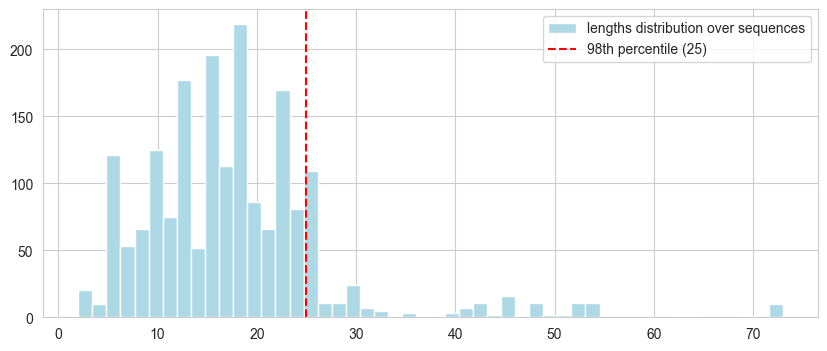

minimun length: 2
maximum length: 73
98th percentile: 25
above 98th percentile: 248 / 1892
below 98th percentile: 1630 / 1892
example of sequence with length 25: 
[[32685 67426 11296 62083 90748  7890   722 89248 63937 89309 92970 74915
  41217 36708 62238 97782 86864 31886 24774 18961 69371 83305 64641 63775
  72413]]


In [24]:
lengths = np.array([len(item) for item in sequences])
percentile_indice = 98
percentile = 25


sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(lengths, bins=50, color="lightblue", label="lengths distribution over sequences")
ax.axvline(x=percentile, linestyle="--", color="red", label=f"{percentile_indice}th percentile ({percentile})")
ax.set_xticks(np.arange(0, 75, 10))
ax.legend()
plt.show()

print(f"minimun length: {np.min(lengths)}")
print(f"maximum length: {np.max(lengths)}")
print(f"{percentile_indice}th percentile: {percentile}")
print(f"above {percentile_indice}th percentile: {sum(lengths>percentile)} / {len(lengths)}")
print(f"below {percentile_indice}th percentile: {sum(lengths<percentile)} / {len(lengths)}")

random_text = ""
while len(random_text) < percentile:
    random_text += lorem.sentence() + " "
print(f"example of sequence with length {percentile}: \n{np.random.randint(0, 99999, (1, percentile))}")

In [25]:
max_length = int(percentile)

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences=sequences, 
                          maxlen=max_length, 
                          padding="post", 
                          truncating="post")

In [27]:
sequences = np.array(sequences)
sequences.shape

(1892, 25)

In [28]:
data_path = "../datasets/clean/final.npy"
np.save(data_path, sequences)